# Supervised Learning: Support Vector Machines

The support vector machine (SVM) is a classification method that attempts to find a hyperplane that separates classes of observations in **feature space**.

In contrast to some other classifications methods we have seen (*e.g.* Bayesian), the SVM does not invoke a probability model for classification; instead, we aim for the direct caclulation of a **separating hyperplane**.

Consider the *logistic regression model*, which transforms a linear combination of predictors with the logistic function.

$$g_{\theta}(x) = \frac{1}{1+\exp(-\theta^{\prime} x)}$$

Notice that when our response is $y=1$, we want the product $\theta^{\prime} x$ to be a very large, positive value so that $g_{\theta}(x) \rightarrow 1$, and when $y=0$, we want this product to be a very large, negative value, so that $g_{\theta}(x) \rightarrow 0$.

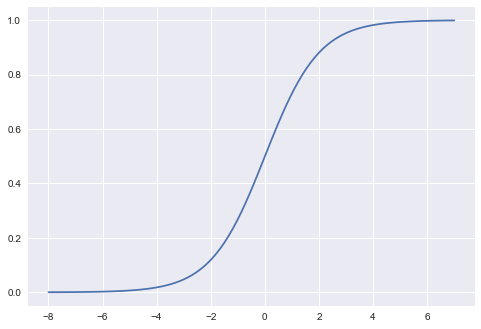

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
                        
invlogit = lambda x, theta: 1. / (1. + np.exp(-x.dot(theta)))

theta = [2, -0.5]
x = np.c_[np.ones(100), np.linspace(-10,20,100)]

y = invlogit(x, theta)

plt.plot(x.dot(theta), y)

The negative log-likelihood (or **cost function**) for the logistic regression model is as follows:

$$l(y_i|\theta,x) = -[y_i \log g_{\theta}(x) + (1-y_i)\log(1-g_{\theta}(x))]$$

Consider the case where $y_i=1$. This implies that the cost function is:

$$l(y_i=1|\theta,x) = - \log \left[ \frac{1}{1+\exp(-\theta\prime x)} \right]$$

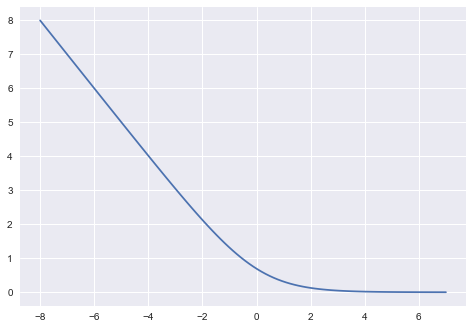

In [6]:
plt.plot(x.dot(theta), -np.log(y))

and when $y_i=0$:

$$l(y_i=0|\theta,x) = - \log \left[ 1 - \frac{1}{1+\exp(-\theta\prime x)} \right]$$

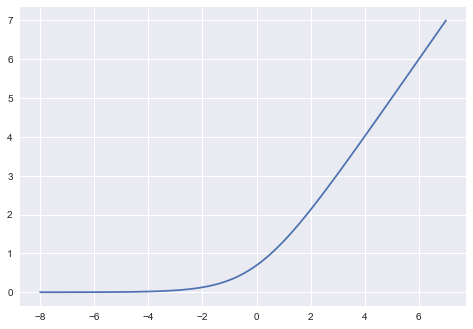

In [7]:
plt.plot(x.dot(theta), -np.log(1.-y))

One way to develop a support vector machine is to modify the logistic regression model by substituting a different cost function, which is just a **piecewise linear function**.

For $y_i=1$:

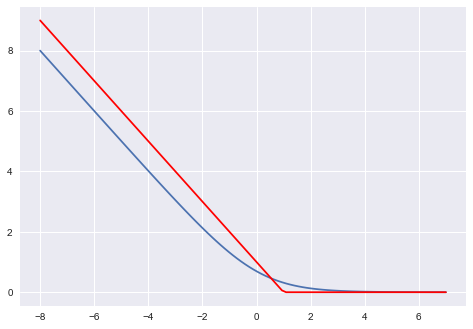

In [8]:
plt.plot(x.dot(theta), -np.log(y))

hinge_cost = lambda x, theta: np.maximum(0, 1 - x.dot(theta))

plt.plot(x.dot(theta), hinge_cost(x, theta), 'r-')

For $y_i=0$:

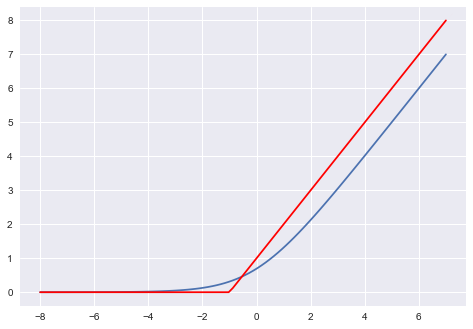

In [9]:
plt.plot(x.dot(theta), -np.log(1-y))

hinge_cost = lambda x, theta: np.maximum(0, 1 + x.dot(theta))

plt.plot(x.dot(theta), hinge_cost(x, theta), 'r-')

Now consider the estimation of the parameters of a *regularized* logistic regression model. This is typically by minimizing:

$$\min_{\theta} \frac{1}{n} \left[ \sum_{i=1}^n y_i -\log g_{\theta}(x_i) + (1-y_i)(-\log(1-g_{\theta}(x_i))) \right] + \frac{\lambda}{2n} \sum_{j=1}^k \theta^2_j$$

for the support vector machine, we instead substitute our cost function (which we will call $k$) in place of the logistic regression likelihood:

$$\min_{\theta} \left[ C \sum_{i=1}^n y_i k_1(\theta^{\prime} x_i) + (1-y_i) k_0(\theta^{\prime} x_i) \right] + \frac{1}{2}\sum_{j=1}^k \theta^2_j$$

where the parameter $C$ is plays a role equivalent to $1/\lambda$.

Notice that to make these cost functions $k$ small, we want $x \ge 1$ or $x \le -1$ rather than just being greater than or less than zero, for $y=1$ or $y=0$, respectively. If we set the parameter $C$ very large, we would want the summation term to be equal or close to zero in order to minimize the overall optimization objective.

This objective then essentially becomes:

$$\min_{\theta} \frac{1}{2} \sum_{j=1}^k \theta^2_j$$

subject to: 

$$\begin{aligned}\theta^{\prime} x_i \ge 1 &\text{ if } y_i=1 \\
\theta^{\prime} x_i \le -1 &\text{ if } y_i=0
\end{aligned}$$

Consider a dataset with two linearly separable groups.

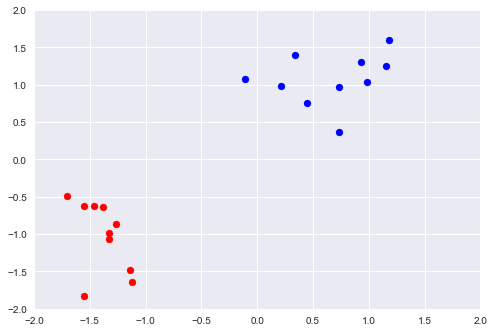

In [10]:
import warnings
warnings.simplefilter('ignore')

g1 = np.random.multivariate_normal((-1,-1), np.eye(2)*0.2, 10)
g2 = np.random.multivariate_normal((1,1), np.eye(2)*0.2, 10)

plt.scatter(*g1.T, color='r')
plt.scatter(*g2.T, color='b')

plt.xlim(-2,2); plt.ylim(-2,2);

One possible separation is a line that passes very close to points in both groups.

In [11]:
x,y = np.transpose([g1[np.where(g1.T[1]==g1.max(0)[1])[0][0]], 
                       g2[np.where(g2.T[1]==g2.min(0)[1])[0][0]]])

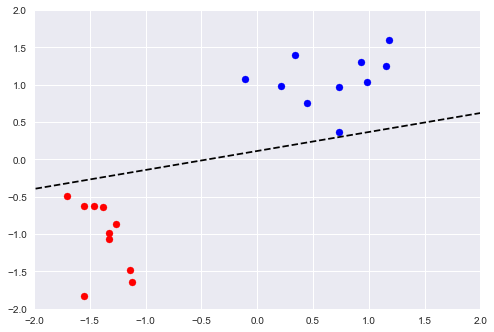

In [12]:
plt.scatter(*g1.T, color='r')
plt.scatter(*g2.T, color='b')

x,y = np.transpose([g1[np.where(g1.T[1]==g1.max(0)[1])[0][0]], 
                       g2[np.where(g2.T[1]==g2.min(0)[1])[0][0]]])
b0,b1 = np.linalg.lstsq(np.c_[[1,1],x], y)[0]
xspace = np.linspace(-3,3,100)
plt.plot(xspace, b0 + (b1-.1)*xspace, 'k--')
plt.xlim(-2,2); plt.ylim(-2,2);

This seems like a poor choice of decision boundary, even though it separates the groups, because it may not be a *robust* solution. SVM avoids this by establishing a **margin** between the decision boundary and the nearest points in each group. This margin is maximized under SVM, and is partly the result of using 1 and -1 as the thresholds for the cost function, rather than zero.

## Large-margin Classification

To understand how SVM incorporates a margin into its decision boundary, it helps to re-write our objective function in terms of the norm (length) of the parameter vector:

$$\min_{\theta} \frac{1}{2} \sum_{j=1}^k \theta^2_j = \min_{\theta} \frac{1}{2} ||\theta||^2$$

Recall that when we take the inner product of two vectors, we are essentially projecting the values of one vector onto the other, in order to add them. In the case of our inner product $\theta^{\prime} x_i$, we are projecting the ith component of $x$ onto the parameter vector $\theta$. We can therefore re-write this inner product in terms of multiplying vector lengths:

$$\theta^{\prime} x_i = p_i ||\theta||$$

where $p_i$ is the **projection** of $x_i$ onto $\theta$. The objective function now becomes:

$$\min_{\theta} \frac{1}{2} ||\theta||^2$$
$$\begin{aligned}
\text{subject to }p_i ||\theta|| \ge 1 &\text{ if } y_i=1 \\
p_i ||\theta|| \le -1 &\text{ if } y_i=0
\end{aligned}$$

In order to satisfy this criterion for a given parameter vector $\theta$, we want the $p_i$ to be *as large as possible*. However, when the decision boundary is close to points in the dataset, the corresponding $p_i$ values will be very small, since they are being projected onto the $\theta$ vector, which is perpendicular to the decision boundary.

Here is a simple graphical illustration of the difference between two boundary choices, in terms of $p_i$ values.

First, a boundary choice that passes closely to the points of each class:

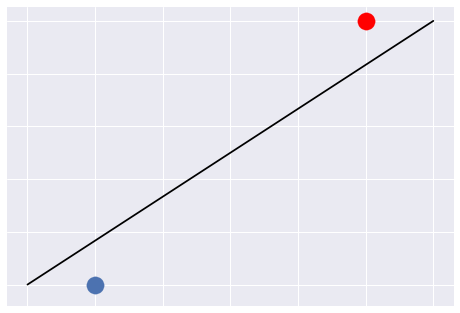

In [13]:
frame = plt.gca()
frame.axes.yaxis.set_ticklabels([])
frame.axes.xaxis.set_ticklabels([])

x1 = -1, 0
x2 = 1, 1

plt.scatter(*x1, s=300, marker='o')
plt.scatter(*x2, s=300, marker='o', color='r')
plt.plot([-1.5, 1.5],[0,1], 'k-');

The vector of parameters $\theta$ of the hyperplane is the **normal vector**, and it is *orthogonal* to the hyperplane surface that we are using as a decision boundary:

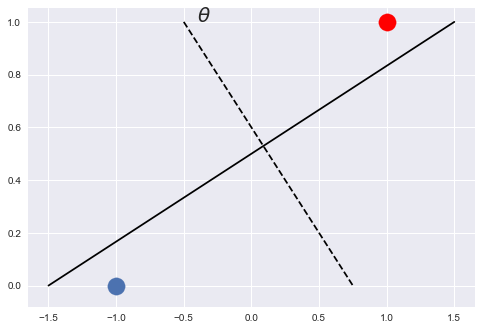

In [14]:
plt.scatter(*x1, s=300, marker='o')
plt.scatter(*x2, s=300, marker='o', color='r')
plt.plot([-1.5, 1.5],[0,1], 'k-')
plt.plot([-.5, .75], [1, 0], 'k--')
plt.annotate(r"$\theta$", xy=(-0.4, 1), fontsize=20);

In order to see what the $p_i$ values will be, we drop perpendicular lines down to the parameter vector $\theta$. Notice that for this decision boundary, the resulting $p_i$ are quite small (either positive or negative). In order to satisfy our constraint, this will force $||\theta||$ to be large, which is not desirable given our objective.

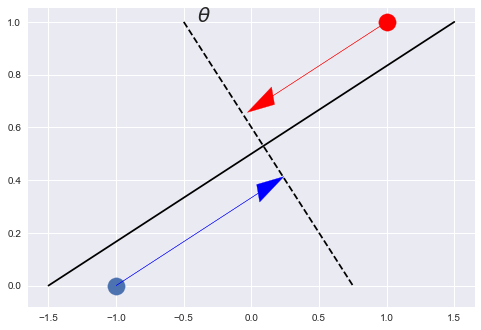

In [15]:
plt.scatter(*x1, s=300, marker='o')
plt.scatter(*x2, s=300, marker='o', color='r')
plt.plot([-1.5, 1.5],[0,1], 'k-')
plt.plot([-.5, .75], [1, 0], 'k--')
plt.annotate(r"$\theta$", xy=(-0.4, 1), fontsize=20)

plt.arrow(-1, 0, 3*(.35), .35, fc="b", ec="b", head_width=0.07, head_length=0.2)
plt.arrow(1, 1, -3*(.28), -.28, fc="r", ec="r", head_width=0.07, head_length=0.2);

Now consider another decision boundary, which intuitively appears to be a better choice.

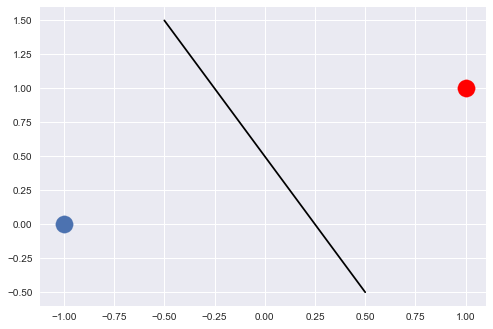

In [16]:
plt.scatter(*x1, s=300, marker='o')
plt.scatter(*x2, s=300, marker='o', color='r')
plt.plot([-.5,.5], [1.5,-.5], 'k-');

We can confirm this in terms of our objective function, by showing the corresponding projections $p_i$ to be large, which allows our parameter vector norm to be smaller.

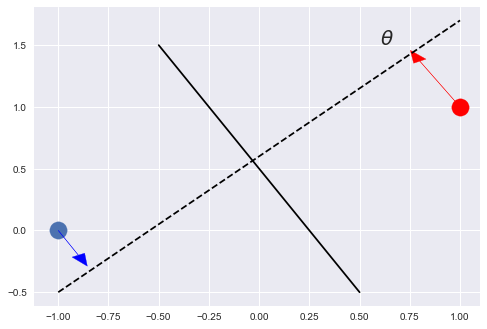

In [17]:
plt.scatter(*x1, s=300, marker='o')
plt.scatter(*x2, s=300, marker='o', color='r')
plt.plot([-.5,.5], [1.5,-.5], 'k-')
plt.plot([-1, 1], [-.5, 1.7], 'k--')
plt.annotate(r"$\theta$", xy=(0.6, 1.5), fontsize=20)

plt.arrow(-1, 0, .1, -.2, fc="b", ec="b", head_width=0.07, head_length=0.1)
plt.arrow(1, 1, -.2, .37, fc="r", ec="r", head_width=0.07, head_length=0.1);

Thus, the values of $\{p_i\}$ define a *margin* that we are attempting to maximize to aid robust classificaction.

## Feature Expansion

In general, when the number of sample points is smaller than the dimension, you can always find a perfect separating hyperplane. On the other hand, when the number of points is large relative to the number of dimensions it is usually impossible.

One way, then, of potentially improving a classifying hyperplane is to increase the dimension of the variable space to create a feature space. One easy way of expanding features is to include transformations of existing variables, such as polynomial expansion.

Let's consider the simplest possible example of two linearly-inseparable classes, using just a single dimensions. Here we have red and blue points distributed along a line.

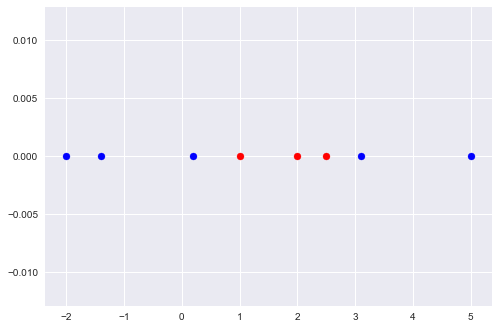

In [18]:
reds = np.array([1, 2, 2.5])
blues = np.array([-2, -1.4, 0.2, 3.1, 5])

plt.scatter(reds, [0]*len(reds), color='r')
plt.scatter(blues, [0]*len(blues), color='b')

Clearly, it is impossible to draw a straight line anywhere that will separate the two classes. However, if we create a feature that is just a quadratic function of the original data, the classes become linearly separable.

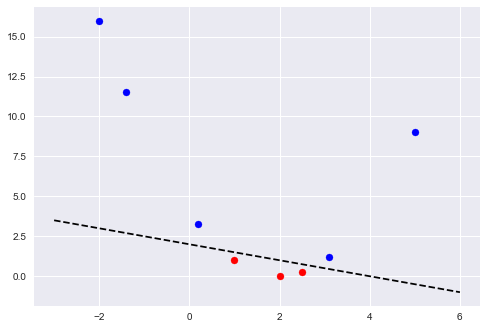

In [19]:
func = lambda x: (x - 2) **2

red_features = [reds, func(reds)]
blue_features = [blues, func(blues)]

plt.scatter(*red_features, color='r')
plt.scatter(*blue_features, color='b')

xvals = np.linspace(-3, 6)
plt.plot(xvals, 2 - 0.5*xvals, 'k--');

More generally, we can create a higher-order polynomial function to use as a decision boundary. For example,

$$y = \left\{ \begin{aligned} 1 &\text{if } \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \theta_3 x_1 x_2 + \theta_4 x_1^2 + \ldots \ge 0 \\
0 &\text{ otherwise}\end{aligned}\right.$$

But, this mapping can substantially *increase the number of features* to consider, and calculating all the polynomial terms can be expensive.

## Kernels

An alternative is to employ a function that measures the similarity between two points in the feature space. Generically, such functions are called **kernels**, and they are characterized by being positive and symmetric, in the sense that for kernel $k$, $k(x,x^{\prime}) = k(x^{\prime}, x)$ (see [Mercer's Theorem](http://www.wikiwand.com/en/Mercer's_theorem)).

You can think of kernels as dot products where we can "cheat" and calculate the value of the dot product between two points without having to explicitly calculate all their feature values. This shortcut is generally referred to as the **kernel trick**


To motivate the need for kernels, let's generate some simulated data which is not linearly separable:

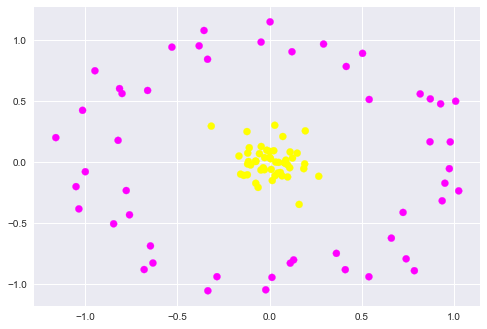

In [20]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

Clearly, no linear discrimination will ever separate these data. One way we can adjust this is to apply a functional transformation of the input data.

For example, one simple kernel we could use is a radial basis function:

In [21]:
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

If we plot our data after being transformed by `r`, we can see that the data becomes linearly separable.

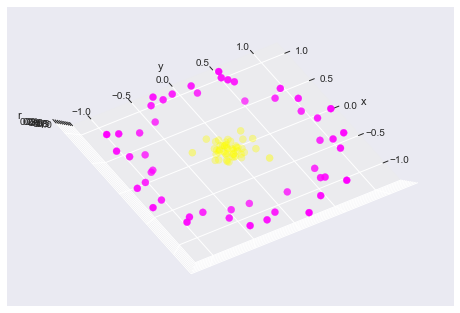

In [22]:
from mpl_toolkits import mplot3d
from IPython.html.widgets import interact

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180));

One common kernel is the Gaussian:

$$k(x, x^{\prime}) = \exp\left[-\frac{||x-x^{\prime}||^2}{2 \sigma^2}\right]$$

Notice that when $x$ and $x^{\prime}$ are close to one another, the numerator approaches zero and $k(x,x^{\prime}) \approx 1$, while when they are far apart the numerator becomes large and $k(x,x^{\prime}) \approx 0$. The parameter $\sigma$ controls how quickly an increased distance causes the value of the kernel to fall toward zero.

If we associate a kernel with *each point* for a particular group that we are using as training examples, our classification function becomes:

$$y = \left\{ \begin{aligned} 1 &\text{if } \theta_0 + \theta_1 k(x,x_1) + \theta_2 k(x,x_2) + \ldots \ge 0\\
0 &\text{ otherwise}\end{aligned}\right.$$

Consider particular values for the parameters, such as $\theta_0=-0.5$ and $\theta_i=1, \, i=1,2,\ldots$. This would result in the function evaluating to approximately 0.5 for a location that is close to any of the points in the set, and to -0.5 for locations that are reasonably far from all the points (as determined by the value of $\sigma$).

For each feature $(x_i, y_i)$ in our dataset, we can calculate the similarity to each feature via the selected kernel:

$$f_i = \left[\begin{align}
k(x_i, &x_0) \\
k(x_i, &x_1) \\
k(x_i, &x_2) \\
\vdots & \\
k(x_i, &x_n)
\end{align}\right]$$

notice that, under the Gaussian kernel at least, there will be one element $k(x_i, x_i)$ that evaluates to 1.

To use the SVM, we use this $f \in \mathbb{R}^{n+1}$ to calculate the inner product $\theta^{\prime} f$ and predict $y_i=1$ if $\theta^{\prime} f_i \ge 0$. We obtain the parameters for $\theta$ by minimizing:

$$\min_{\theta} \left[ C \sum_{i=1}^n y_i k_1(\theta^{\prime} f_i) + (1-y_i) k_0(\theta^{\prime} f_i) \right] + \frac{1}{2}\sum_{j=1}^k \theta^2_j$$


### Regularization and soft margins

There remains a choice to be made for the values of the SVM parameters. Recall $C$, which corresponds to the inverse of the regularization parameter in a lasso model. This choice of $C$ involves a **bias-variance tradeoff**:

* large C = low bias, high variance
* small C = high bias, low variance

In a support vector machine, regularization results in a **soft margin** that allows some points to cross the optimal decision boundary (resulting in misclassifiction for those points). As C gets larger, the more stable the margin becomes, since it is allowing more points to determine the margin.

We can think of C as a "budget" for permitting points to exceed the margin. We can tune C to determine the optimal hyperplane.

Similarly, if we are using the Gaussian kernel, we must choose a value for $\sigma^2$. When $\sigma^2$ is large, then features are considered similar over greater distances, resulting in a smoother decision boundary, while for smaller $\sigma^2$, similarity falls off quickly with distance.

* large $\sigma^2$ = high bias, low variance
* small $\sigma^2$ = low bias, high variance

### Linear kernel

The simplest choice of kernel is to use no kernel at all, but rather to simply use the **linear combination** of the features themselves as the kernel. Hence,

$$y = \left\{ \begin{aligned} 1 &\text{, if } \theta^{\prime} x \ge 0\\
0 &\text{ otherwise}\end{aligned}\right.$$

This approach is useful when there are a *large number of features*, but the *size of the dataset is small*. In this case, a simple linear decision boundary may be appropriate given that there is relatively little data. If the reverse is true, where there are a small number of features and plenty of data, a Gaussian kernel may be more appropriate, as it allows for a more complex decision boundary.

## Multi-class Classification

In the exposition above, we have addressed binary classification problems. The SVM can be generalized to multi-class classification. This involves training $K$ binary classifiers, where each of $k=1,\ldots,K$ classes is trained against the remaining classes pooled into a single group ("all-versus-one"). Then for each point, we select the class for which the inner product $\theta_k^{\prime} x$ is largest.

## Data Preprocessing

It is important with many kernels to **scale** the features prior to using them in a SVM. This is because features which are numerically large relative to the others will tend to dominate the norm. So that each feature is able to contribute equally to the selection of the decision boundary, we want them all to have approximately the same range.

In general, standardization of datasets is a common pratice for statistical learning algorithms. We often ignore the shape of the data distribution and simply center it on the mean, then scale it by dividing by their standard deviation (unless the feature is constant). This is important because the objective function in several learning algorithms (*e.g.* the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features.

Scikit-learn's `preprocessing` module provides a `scale` function to perform this operation on a single array-like dataset:

In [23]:
from sklearn import preprocessing

X = np.array([[ 1., -1.,  2.],
                [ 2.,  0.,  0.],
                [ 0.,  1., -1.]])
X_scaled = preprocessing.scale(X)
X_scaled                                          

array([[ 0.        , -1.22474487,  1.33630621],
       [ 1.22474487,  0.        , -0.26726124],
       [-1.22474487,  1.22474487, -1.06904497]])

Scaled data has zero mean and unit variance:

In [24]:
X_scaled.mean(0)

array([ 0.,  0.,  0.])

In [25]:
X_scaled.std(0)

array([ 1.,  1.,  1.])

The `preprocessing` module also provides a utility class called `StandardScaler` that allows for the computation of the mean and standard deviation on a training set. This allows one to later *reapply* the same transformation on validation and test sets.

In [26]:
scaler = preprocessing.StandardScaler().fit(X)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [27]:
scaler.mean_                                      

array([ 1.        ,  0.        ,  0.33333333])

In [28]:
scaler.scale_                                       

array([ 0.81649658,  0.81649658,  1.24721913])

In [29]:
scaler.transform(X)               

array([[ 0.        , -1.22474487,  1.33630621],
       [ 1.22474487,  0.        , -0.26726124],
       [-1.22474487,  1.22474487, -1.06904497]])

So then, for new data, we can simply apply the `scaler` object's `transform` method:

In [30]:
scaler.transform([[-1.,  1., 0.]]) 

array([[-2.44948974,  1.22474487, -0.26726124]])

Optionally, one can disable either centering or scaling by passing `with_mean=False` or `with_std=False`, respectively.

### Range scaling

An alternative standardization is scaling features to lie between a given minimum and maximum value (typically between zero and one). This is often the case where we want robustness to very small standard deviations of features or we want to preserve zero entries in sparse data.

The `MinMaxScaler` provides this scaling.

In [31]:
min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit_transform(X)

array([[ 0.5       ,  0.        ,  1.        ],
       [ 1.        ,  0.5       ,  0.33333333],
       [ 0.        ,  1.        ,  0.        ]])

The same instance of the transformer can then be applied to some new test data, which results in the same scaling and shifting operations:

In [32]:
X_test = np.array([[ -3., -1.,  4.]])
min_max_scaler.transform(X_test)

array([[-1.5       ,  0.        ,  1.66666667]])

### Normalization

Normalization is the process of scaling individual samples to have unit norm. This is useful if you plan to use a quadratic function such as the dot-product or any other kernel to quantify the similarity of any pair of samples.

The function `normalize` performs this operation on a single array-like dataset, either using the l1 or l2 norms:

In [33]:
preprocessing.normalize(X, norm='l2')

array([[ 0.40824829, -0.40824829,  0.81649658],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678, -0.70710678]])

In [34]:
preprocessing.normalize(X, norm='l1')

array([[ 0.25, -0.25,  0.5 ],
       [ 1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.5 , -0.5 ]])

As with scaling, there is also a `Normalizer` class that can be used to establish normalization with respect to a training set.

In [35]:
normalizer = preprocessing.Normalizer().fit(X)

In [36]:
normalizer.transform(X_test)

array([[-0.58834841, -0.19611614,  0.78446454]])

### Categorical feature encoding

Often features are not given as continuous values, but rather as categorical classes. For example, variables may be defined as `["male", "female"]`, `["Europe", "US", "Asia"]`, `["Disease A", "Disease B", "Disease C"]`. Such features can be efficiently coded as integers, for instance `["male", "US", "Disease B"]` could be expressed as `[0, 1, 1]`.

Unfortunately, an integer representation can not be used directly with estimators in scikit-learn, because these expect *continuous* input, and would therefore interpret the categories as being ordered, which for the above examples, would be inappropriate.

One approach is to use a "one-of-K" or "one-hot" encoding, which is implemented in `OneHotEncoder`. This estimator transforms a categorical feature with `m` possible values into `m` binary features, with only one active.

In [37]:
enc = preprocessing.OneHotEncoder()

In [38]:
enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]]) 

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [39]:
enc.transform([[0, 1, 3]]).toarray()

array([[ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]])

By default, the cardinality of each feature is inferred automatically from the dataset; this can be manually overriden using the `n_values` argument.

`LabelBinarizer` is a utility class to help create a label indicator matrix from a list of multi-class labels:

In [40]:
lb = preprocessing.LabelBinarizer()
lb.fit([1, 2, 6, 4, 2])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [41]:
lb.classes_

array([1, 2, 4, 6])

In [42]:
lb.transform((1,4))

array([[1, 0, 0, 0],
       [0, 0, 1, 0]])

For multiple labels per instance, use MultiLabelBinarizer:

In [43]:
lb = preprocessing.MultiLabelBinarizer()
lb.fit_transform([(1, 2), (3,)])

array([[1, 1, 0],
       [0, 0, 1]])

In [44]:
lb.classes_

array([1, 2, 3])

`LabelEncoder` is a utility class to help normalize labels such that they contain only consecutive values between 0 and `n_classes-1`.

In [45]:
le = preprocessing.LabelEncoder()
le.fit([1,2,2,6])

LabelEncoder()

In [46]:
le.classes_

array([1, 2, 6])

In [47]:
le.transform([1, 1, 2, 6])

array([0, 0, 1, 2])

In [48]:
le.inverse_transform([0, 0, 1, 2])

array([1, 1, 2, 6])

## Missing Data Imputation

Missing data is a common problem in most real-world scientific datasets. While the best way for dealing with missing data will always be preventing their occurrence in the first place, it usually can't be helped, particularly when data are collected passively or voluntarily, or when data collection and recording is distributed among several people. There are a variety of ways for dealing with missing data, from the very naïve to the very sophisticated, and unfortunately the more common approaches tend to be *ad hoc* and will usually do more harm than good. 

It turns out that more robust methods for imputation are not as difficult to implement as they first appear to be. Two of the best ones are Bayesian imputation and multiple imputation. In this section, we will use **multiple imputation** to account for missing data in a regression analysis. 

As a motivating example, we will use a dataset of educational outcomes for children with hearing impairment. Here, we are interested in determining factors that are associated with better or poorer learning outcomes. 

![hearing aid](images/hearing_aid.jpg)

There is a suite of available predictors, including: 

* gender (`male`)
* number of siblings in the household (`siblings`)
* index of family involvement (`family_inv`)
* whether the primary household language is not English (`non_english`)
* presence of a previous disability (`prev_disab`)
* non-white race (`non_white`)
* age at the time of testing (in months, `age_test`)
* whether hearing loss is not severe (`non_severe_hl`)
* whether the subject's mother obtained a high school diploma or better (`mother_hs`)
* whether the hearing impairment was identified by 3 months of age (`early_ident`).

In [50]:
test_scores = pd.read_csv('test_scores.csv', index_col=0)
test_scores.head()

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


For three variables in the dataset, there are incomplete records.

In [51]:
test_scores.isnull().sum(0)

score             0
male              0
siblings          0
family_inv       33
non_english       0
prev_disab       18
age_test          0
non_severe_hl     0
mother_hs        73
early_ident       0
non_white         0
dtype: int64

### Strategies for dealing with missing data

The easiest (and worst) way to deal with missing data is to **ignore it**. That is, simply run the analysis, missing values and all, hoping for the best. If your software is any good, this approach will simply not work; the algorithm will try to operate on data that includes missing values, and propagate them, resulting in statistics and estimates that cannot be calculated, which will typically raise errors. If your software is poor, it will make some assumption or decision about the missing values, and proceed to generate  results conditional on the assumption, which creates problems that may never be detected because no indication was given to any potential problem. 

The next easiest (worst) approach to analyzing data with missing values is to conduct list-wise deletion, by deleting the records that have missing values. This is called **complete case analysis**, because only records that are complete get retained for the analysis. The degree to which complete case analysis is undesirable depends on the mechanism by which data have become missing.

### Types of Missingness

- **Missing completely at random (MCAR)**: When data are MCAR, missing cases are, on average, identical to non-missing cases, with respect to the model. Ignoring the missingness will reduce the power of the analysis, but will not bias inference.
- **Missing at random (MAR)**: Missing data depends (usually probabilistically) on measured values, and hence can be modeled by variables observed in the data set. Accounting for the values which “cause” the missing data will produce unbiased results in an analysis.
- **Missing not at random(MNAR)**: Missing data depend on unmeasured or unknown variables. There is no information available to account for the missingness.

The very best-case scenario for using complete case analysis, which corresponds to MCAR missingness, results in a **loss of power** due to the reduction in sample size. The analysis will lose the information contained in the non-missing elements of a partially-missing record. When data are not missing completely at random, inferences from complete case analysis may be **biased** due to systematic differences between missing and non-missing records that affects the estimates of key parameters.

One alternative to complete case analysis is to simply fill (*impute*) the missing values with a reasonable guess a the true value, such as the mean, median or modal value of the fully-observed records. This imputation, while not recovering any information regarding the missing value itself for use in the analysis, does provide a mechanism for including the non-missing values in the analysis, thereby making use of all available information.

The `Imputer` class in scikit-learn provides methods for imputing missing values, either using the mean, the median or the most frequent value of the row or column in which the missing values are located. This class also allows for different missing value encodings.

For example, we can replace missing entries encoded as `np.nan` using the mean value of the columns (axis 0) that contain the missing values:

In [ ]:
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

In [ ]:
imp.fit([[1, 2], [np.nan, 3], [7, 6]])

In [ ]:
X = [[np.nan, 1], [6, np.nan], [3, 6]]
imp.transform(X)

In our educational outcomes dataset, we are probably better served using mode imputation:

In [ ]:
mode_imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)

In [ ]:
mode_imp.fit(test_scores)

In [ ]:
mode_imp.transform(test_scores)[:3]

Of course, in Python it is often easier to impute data using Pandas `DataFrame` method `fillna`.

In [ ]:
test_scores.siblings.mean()

In [ ]:
siblings_imputed = test_scores.siblings.fillna(test_scores.siblings.mean())

This approach may be reasonable under the MCAR assumption, but may induce bias under a MAR scenario, whereby missing values may **differ systematically** relative to non-missing values, making the particular summary statistic used for imputation *biased* as a mean/median/modal value for the missing values.

Beyond this, the use of a single imputed value to stand in place of the actual missing value glosses over the **uncertainty** associated with this guess at the true value. Any subsequent analysis procedure (*e.g.* regression analysis) will behave as if the imputed value were observed, despite the fact that we are actually unsure of the actual value for the missing variable. The practical consequence of this is that the variance of any estimates resulting from the imputed dataset will be **artificially reduced**.

## Multiple Imputation

One robust alternative to addressing missing data is **multiple imputation** (Schaffer 1999, van Buuren 2012). It produces unbiased parameter estimates, while simultaneously accounting for the uncertainty associated with imputing missing values. It is conceptually and mechanistically straightforward, and produces complete datasets that may be analyzed using any statistical methodology or software one chooses, as if the data had no missing values to begin with.

Multiple imputation generates imputed values based on a **regression model**. This regression model will help us generate reasonable values, particularly if data are MAR, since it uses information in the dataset that may be informative in predicting what the true value may be. Ideally, we want predictor variables that are **correlated** with the missing variable, and with the mechanism of missingness, if any. For example, one might be able to use test scores from one subject to predict missing test scores from another; or, the probability of income reporting to be missing may vary systematically according to the education level of the individual.

To see if there is any potential information among the variables in our dataset to use for imputation, it is helpful to calculate the pairwise correlation between all the variables. Since we have discrete variables in our data, the [Spearman rank correlation coefficient](http://www.wikiwand.com/en/Spearman%27s_rank_correlation_coefficient) is appropriate.

In [ ]:
test_scores.dropna().corr(method='spearman')

We will try to impute missing values the mother's high school education indicator variable, which takes values of 0 for no high school diploma, or 1 for high school diploma or greater. The appropriate model to predict binary variables is a **logistic regression**. We will use the scikit-learn implementation, `LogisticRegression`.

In [ ]:
from sklearn.linear_model import LogisticRegression

To keep things simple, we will only use variables that are themselves complete to build the predictive model, hence our subset of predictors will exclude family involvement score (`family_inv`) and previous disability (`prev_disab`).

In [ ]:
impute_subset = test_scores.drop(labels=['family_inv','prev_disab','score'], axis=1)

Next, we scale the predictor variables to range from 0 to 1, to improve the performance of the regression model.

In [ ]:
y = impute_subset.pop('mother_hs').values
X = preprocessing.StandardScaler().fit_transform(impute_subset.astype(float))

Next, we create a `LogisticRegression` model, and fit it using the non-missing observations.

In [ ]:
missing = np.isnan(y)

mod = LogisticRegression()
mod.fit(X[~missing], y[~missing])

In [ ]:
mother_hs_pred = mod.predict(X[missing])
mother_hs_pred

These values can then be inserted in place of the missing values, and an analysis can be performed on the entire dataset.

However, this is still just a single imputation for each missing value, and hence glosses over the uncertainty associated with the derivation of the imputes. Multiple imputation proceeds by **imputing several values**, to generate several complete datasets and performing the same analysis on all of them. With a set of estimates in hand, an *average* estimate of model parameters can be obtained that more adequately accounts for the uncertainty, hopefully providing more robust inference than from a single impute.

There are a variety of ways to generate multiple imputations. Here, we will exploit **regularization** in order to do this. The `LogisticRegression` class from scikit-learn provides facilities for regularization using either L2 (resulting in ridge regression) or L1 (resulting in LASSO regression) penalties. The degree of regularization in either case is controlled by the `C` parameter, whereby large values of `C` give more freedom to the model, while smaller values of `C` constrain the model more. We can use a selection of `C` values to obtain a range of predictions from variants of the same model. For example:

In [ ]:
mod2 = LogisticRegression(C=1, penalty='l1')
mod2.fit(X[~missing], y[~missing])
mod2.predict(X[missing])

In [ ]:
mod3 = LogisticRegression(C=0.4, penalty='l1')
mod3.fit(X[~missing], y[~missing])
mod3.predict(X[missing])

Surprisingly few imputations are required to acheive reasonable estimates, with 3-10 usually sufficient. We will use 3.

In [ ]:
mother_hs_imp = []

for C in 0.1, 0.4, 2:
    
    mod = LogisticRegression(C=C, penalty='l1')
    mod.fit(X[~missing], y[~missing])
    imputed = mod.predict(X[missing])
    mother_hs_imp.append(imputed)

In [ ]:
mother_hs_imp

## SVM using `scikit-learn`

The scikit-learn machine learning package for Python includes a nice implementation of support vector machines.

In [ ]:
from sklearn import svm

Let's begin with a fun enological example. Your textbook includes a dataset `wine.dat` that is the result of chemical analyses of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines. (The response variable is incorrectly labeled `region`; it should be the grape from which the wine was derived). We might be able to correctly classify a given wine based on its chemical profile.

To illustrate the characteristics of the SVM, we will select two attributes, which will make things easy to visualize.

In [ ]:
wine = pd.read_table("../data/textbook/wine.dat", sep='\s+')

attributes = ['Alcohol',
            'Malic acid',
            'Ash',
            'Alcalinity of ash',
            'Magnesium',
            'Total phenols',
            'Flavanoids',
            'Nonflavanoid phenols',
            'Proanthocyanins',
            'Color intensity',
            'Hue',
            'OD280/OD315 of diluted wines',
            'Proline']

grape = wine.pop('region')
y = grape.values
wine.columns = attributes
X = wine[['Alcohol', 'Proline']].values

svc = svm.SVC(kernel='linear')
svc.fit(X, y)

In [ ]:
wine.head()

It is easiest to display the model fit graphically, by evaluating the model over a grid of points.

In [ ]:
from matplotlib.colors import ListedColormap
# Create color maps for 3-class classification problem, as with iris
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_estimator(estimator, X, y):
    
    try:
        X, y = X.values, y.values
    except AttributeError:
        pass
    
    estimator.fit(X, y)
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.axis('tight')
    plt.axis('off')
    plt.tight_layout()

In [ ]:
plot_estimator(svc, X, y)

The SVM gets its name from the samples in the dataset from each class that lie closest to the other class. These training samples are called **support vectors** because changing their position in *p*-dimensional space would change the location of the decision boundary. 

In scikits-learn, the indices of the support vectors for each class can be found in the `support_vectors_` attribute of the `SVC` object. Here is a 2 class problem using only classes 1 and 2 in the wine dataset.

The support vectors are circled.

In [ ]:
# Extract classes 1 and 2
X, y = X[np.in1d(y, [1, 2])], y[np.in1d(y, [1, 2])]

plot_estimator(svc, X, y)
plt.scatter(svc.support_vectors_[:, 0], 
           svc.support_vectors_[:, 1], 
           s=120, 
           facecolors='none', 
           linewidths=2,
           zorder=10)

Clearly, these classes are not linearly separable.

As we learned, regularization is tuned via the $C$ parameter. In practice, a large $C$ value means that the number of support vectors is small (less regularization), while a small $C$ implies many support vectors (more regularization). scikit-learn sets a default value of $C=1$.

In [ ]:
@interact(power=[-2,6])
def plot_regularized(power):
    svc = svm.SVC(kernel='linear', C=10**power)
    plot_estimator(svc, X, y)
    plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=80, 
            facecolors='none', linewidths=2, zorder=10)
    plt.title('High C values: small number of support vectors')

We can choose from a suite of available kernels (`linear`, `poly`, `rbf`, `sigmoid`, `precomputed`) or a custom kernel can be passed as a function. Note that the radial basis function (`rbf`) kernel is just a Gaussian kernel, but with parameter $\gamma=1/\sigma^2$.

In [ ]:
@interact(degree=[0,10])
def plot_poly_svc(degree=3):
    svc_poly = svm.SVC(kernel='poly', degree=degree)
    plot_estimator(svc_poly, X, y)
    plt.scatter(svc_poly.support_vectors_[:, 0], svc_poly.support_vectors_[:, 1], 
               s=80, facecolors='none', linewidths=2, zorder=10)
    plt.title('Polynomial kernel')

In [ ]:
@interact(power=[-2,5])
def plot_rbf_svc(power=1):
    
    svc_rbf = svm.SVC(kernel='rbf', gamma=10**power)
    plot_estimator(svc_rbf, X, y)
    plt.scatter(svc_rbf.support_vectors_[:, 0], svc_rbf.support_vectors_[:, 1], 
               s=80, facecolors='none', linewidths=2, zorder=10)
    plt.title('RBF kernel')

Of course, the radial basis function (RBF) kernel is very flexible and performs best for this dataset. However, it is easy to get carried away tuning to a training dataset--we don't really believe the resulting decision boundary, do we?

## Cross-validation

In order to make objective choices for either kernels or hyperparameter values, we can apply the cross-validation methods outlined in last week's lecture. Every estimator class in `scikit-learn` exposes a `score` method that can judge the quality of the fit (or the prediction) on new data.

The `score(x,y)` method for the `SVC` class returns the *mean accuracy* of the predictions from `x` with respect to `y`, for the fitted SVM.

In [ ]:
svc_lin = svm.SVC(kernel='linear', C=2)
svc_lin.fit(X, y)
svc_lin.score(X, y)

In [ ]:
svc_poly = svm.SVC(kernel='poly', degree=3)
svc_poly.fit(X, y)
svc_poly.score(X, y)

In [ ]:
svc_rbf = svm.SVC(kernel='rbf', gamma=1e-2)
svc_rbf.fit(X, y)
svc_rbf.score(X, y)

Each estimator in `scikit-learn` has a default estimator score method, which is an evaluation criterion for the problem they are designed to solve. For the `SVC` class, this is the **mean accuracy**, as shown above.

Alternately, if we use cross-validation, you can specify one of a set of built-in scoring metrics. For classifiers such as support vector machines, these include:

**accuracy**
:	`sklearn.metrics.accuracy_score`

**average_precision**
:	`sklearn.metrics.average_precision_score`

**f1**
:	`sklearn.metrics.f1_score`

**precision**
:	`sklearn.metrics.precision_score`

**recall**
:	`sklearn.metrics.recall_score`

**roc_auc**
:	`sklearn.metrics.roc_auc_score`

Regression models can use appropriate metrics, like `mean_squared_error` or `r2`.

Finally, one can specify arbitrary loss functions to be used for assessment. The `metrics` module implements functions assessing prediction errors for specific purposes. 

In [ ]:
def custom_loss(observed, predicted):
    diff = np.abs(observed - predicted).max()
    return np.log(1 + diff)

In [ ]:
from sklearn.metrics import make_scorer
custom_scorer = make_scorer(custom_loss, greater_is_better=False)

Implementing cross-validation on our wine SVC is straightforward:

In [ ]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(
        wine.values, grape.values, test_size=0.4, random_state=0)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_test.shape, y_test.shape

In [ ]:
f = svm.SVC(kernel='linear', C=1)
f.fit(X_train, y_train)
f.score(X_test, y_test)

The following example demonstrates how to estimate the accuracy of a linear kernel support vector machine on the wine dataset by splitting the data, fitting a model and computing the score 5 consecutive times (with different splits each time):

In [ ]:
scores = model_selection.cross_val_score(f, wine.values, grape.values, cv=5)
scores

In [ ]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Furthermore, we can customize the scoring method by specifying the `scoring` parameter:

In [ ]:
model_selection.cross_val_score(f, wine.values, grape.values, cv=5,
                                 scoring='f1_weighted')

The module `sklearn.metric` also exposes a set of simple functions measuring prediction error given observations and prediction, such as the confusion matrix:

In [ ]:
from sklearn.metrics import confusion_matrix

svc_poly = svm.SVC(kernel='poly', degree=3).fit(X_train, y_train)
confusion_matrix(y_test, svc_poly.predict(X_test))

## Exercise: Titanic survival

Try to estimate a reasonable support vector classfier for the fate of passengers on the Titanic (`../data/titanic.xls`). Specifically, see if you can correctly classify the survivors based on the covariates available in the dataset.

As an extension, use multiple imputation to allow for the inclusion of age into the analysis, and see if it makes a difference in the results.

In [ ]:
!conda install -y xlrd

In [53]:
titanic = pd.read_excel("titanic.xls", "titanic")
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [ ]:
# Write answer here

## References

[Coursera's Machine Learning course](https://www.coursera.org/course/ml) by Stanford's Andrew Ng

[`scikit-learn` User's Guide](http://scikit-learn.org/stable/modules/svm.html) SVM section

[Scikit-learn tutorials for the Scipy 2013 conference](https://github.com/jakevdp/sklearn_scipy2013) by Jake Vanderplas